# Content

**Supervised:** The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features  
**Classification:** The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

- Evaluation des performances des modèles d’apprentissage supervisé selon différents critères (scores, temps d'entraînement, etc.) en adaptant les paramètres afin de choisir le modèle le plus performant pour la problématique métier.
- Calcul un score avec fp + 10 * fn

precision, recall, accuracy, roc_auc, f1
        fbeta_macro
        fbeta_micro
        fbeta_weighted
        
hyperparameter search for the following methods: XGBoost, LightGBM, Random Forest. Save each model, best parameters and evaluation metrics with MLflow. Save the evaluation metrics for all models to a dataframe.

- [ 0 - Library definition](#0) 
- [ 1 - Data definition](#1) 
- [ 1.1 - Imbalanced Data Definition](#1.1) 
- [ 2 - Metrics definition](#2) 
- [ 3 - Model definition](#3) 
- [ 4 - Run 1 EXPERIMENT with 6 RUNs](#4)
- [ 5 - Model Evaluation](#(5)
- [ 6 - Feature Importance](#(6)
- [ 7 - Feature Selection after SHAP feature Importance](#(7)

<a name='0'></a>
# 0 Library definition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import auc
from sklearn.metrics import fbeta_score

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import mlflow
import mlflow.sklearn
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature

from prettytable import PrettyTable

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where
import shap

In [2]:
help(xgb.__version__)

No Python documentation found for '1.7.0'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.



In [3]:
#pip uninstall xgboost
#!pip install xgboost==1.7.0

<a name='1'></a>
# 1 Data definition

In [4]:
X_train = pd.read_csv('../2_INPUT_DATA/3_SPLIT/X_train.csv')
Y_train = pd.read_csv('../2_INPUT_DATA/3_SPLIT/Y_train.csv')
X_test = pd.read_csv('../2_INPUT_DATA/3_SPLIT/X_test.csv')
Y_test = pd.read_csv('../2_INPUT_DATA/3_SPLIT/Y_test.csv')
ids_test = pd.read_csv('../2_INPUT_DATA/3_SPLIT/ids_test.csv')
feature_names = pd.read_csv('../2_INPUT_DATA/2_FEATURE_PROCESSED/feature_names.csv')

print("X_train", X_train.shape)
print("Y_train", Y_train.shape)
print("Y_test", Y_test.shape)
print("ids_test",ids_test.shape)
print("feature names", feature_names.shape)

X_train (246008, 239)
Y_train (246008, 1)
Y_test (61503, 1)
ids_test (246008, 1)
feature names (239, 1)


In [5]:
def scale_data(df_train, df_test):
    """
    Scale the features in the training and testing datasets using Min-Max scaling.

    Args:
    df_train (DataFrame): The training dataset to be scaled.
    df_test (DataFrame): The testing dataset to be scaled.

    Returns:
    df_train_scaled (DataFrame): The scaled training dataset.
    df_test_scaled (DataFrame): The scaled testing dataset.
    """
    # Initialize MinMaxScaler with feature range between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit and transform the training dataset
    df_train_scaled = scaler.fit_transform(df_train)

    # Transform the testing dataset using the same scaler fitted on the training data
    df_test_scaled = scaler.transform(df_test)

    return df_train_scaled, df_test_scaled

In [6]:
#test = X_train.copy()
#test["ID"] = ids_test
#test.set_index("ID", inplace=True)
#ids_test.iloc[5]
#test.loc[100008].values.tolist()

<a name='1.1'></a>
# 1.1 Imbalanced Data treatment

Counter({0: 226067, 1: 19941})


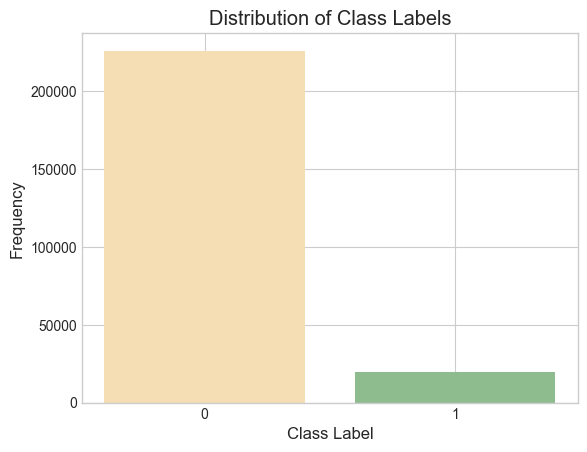

Counter({0: 45212, 1: 22606})


In [38]:

def SMOTE_transformation(X, y):
    # summarize class distribution
    #plt.style.use('seaborn-v0_8-whitegrid')
    plt.style.use('seaborn-v0_8-pastel')
    counter = Counter(y)
    print(counter)
    plt.bar(counter.keys(), counter.values(), color = ['darkseagreen', 'wheat'])
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.title('Distribution of Class Labels')
    class_labels = [0, 1]
    # Set xticks and yticks to integer values
    plt.xticks(range(len(class_labels)), class_labels)
    #plt.yticks(range(max(counter.values()) + 1))  # Range up to the maximum count
    plt.show()
    # define pipeline
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X, y = pipeline.fit_resample(X, y)
    # summarize the new class distribution
    counter = Counter(y)
    print(counter)
    # scatter plot of examples by class label
    #for label, _ in counter.items():
    #    print(label)
    #    row_ix = where(y == label)[0]
    #    print(row_ix)
    #    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))

    #pyplot.legend()
    #pyplot.show()
    
    return X, y

x_train_smote, y_train_smote = SMOTE_transformation(X_train, Y_train['TARGET'])

In [17]:
x_train_smote.shape

(67818, 239)

<a name='2'></a>
# 2 Metrics definition

**Fbeta Score**

![alt text for screen readers](IMAGES/fbetascore.png "Fbeta Score")

A smaller beta value, such as 0.5, gives more weight to precision and less to recall, whereas a larger beta value, such as 2.0, gives less weight to precision and more weight to recall in the calculation of the score.

#### FN et FP  
On simule la supposition, que le coût d’un FN est dix fois supérieur au coût d’un FP.  
On crée un score “métier” en minimisant le coût d’erreur de prédiction des FN et FP pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres.

**Precision**  
(tp / (tp + fp))
It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.  

**Recall** is the same as sensitivity.
(tp / (tp + fn)    
Recall describes how good the model is at predicting the positive class when the actual outcome is positive.


We want to optimize recall.

In [8]:
def fbeta_score_calculation(y_true, y_pred):
    fbeta_macro = fbeta_score(y_true, y_pred, average='macro', beta=2)
    fbeta_micro = fbeta_score(y_true, y_pred, average='micro', beta=2)
    fbeta_weighted = fbeta_score(y_true, y_pred, average='weighted', beta=2)
    return round(fbeta_macro,2), round(fbeta_micro,2), round(fbeta_weighted,2)

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
def reminder_TP(TN="", FP="", FN="", TP=""):
    #tn, fp, fn, tp
    # Create a PrettyTable instance
    table = PrettyTable()

    # Define columns and headers
    table.field_names = ['Confusion Matrix', 'Positive prediction', 'Negative prediction']

    # Add rows
    table.add_row(['Positive class', 'True positive (TP)', 'False negative (FN)'])
    table.add_row(['Negative class', 'False positive (FP)', 'True negative (TN)'])

    # Print the table
    print(table)
    
    if TN :
        # Create a PrettyTable instance
        table2 = PrettyTable()

        # Define columns and headers
        table2.field_names = ['Confusion Matrix', 'Positive prediction', 'Negative prediction']

        # Add rows
        table2.add_row(['Positive class', TP, FN])
        table2.add_row(['Negative class', FP, TN])

        # Print the table
        print(table2)
    

def generate_recall_precision_curve(model, X_test, Y_test):
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(Y_test, lr_probs)
    lr_f1, lr_auc = f1_score(Y_test, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(Y_test[Y_test==1]) / len(Y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    pass

def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

def generate_model_report(model, model_name, X_test, Y_test, trainT):
    print("\n---------------------------------")
    print("start generate_model_report")
    
    Y_Test_Pred_best_param = model.predict(X_test)
    
    generate_auc_roc_curve(model, X_test)
    generate_recall_precision_curve(model, X_test, Y_test)
    
    cm = confusion_matrix(np.array(Y_test), Y_Test_Pred_best_param  )
    tn, fp, fn, tp = cm.ravel()
    reminder_TP(tn, fp, fn, tp)
    
    roc_auc = roc_auc_score(np.array(Y_test), Y_Test_Pred_best_param)

    bu_Sc = fp + (10*fn) #business score FN cost 10 times more than fp
    ac_Sc = accuracy_score(np.array(Y_test), Y_Test_Pred_best_param)
    pr_Sc = precision_score(np.array(Y_test), Y_Test_Pred_best_param)
    re_Sc = recall_score(np.array(Y_test), Y_Test_Pred_best_param)
    F1_Sc = f1_score(np.array(Y_test), Y_Test_Pred_best_param)
    fbeta_macro, fbeta_micro, fbeta_weighted = fbeta_score_calculation(np.array(Y_test), Y_Test_Pred_best_param)
    print('ROC AUC: ', roc_auc)
    print("Accuracy = " , accuracy_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("Precision = " ,precision_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("Recall = " ,recall_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("F1 Score = " ,f1_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("Fbeta Score = " ,fbeta_score_calculation(np.array(Y_test), Y_Test_Pred_best_param))
    
    metrics = pd.DataFrame({'model': model_name,'tn': [tn], 'fp': [fp], 'fn': [fn], 'tp': [tp],'FP+10*FN': bu_Sc,
                            'accuracy': [ac_Sc], 
                            'ROC_AUC': [roc_auc],
                            'precision': [pr_Sc],
                            'recall': [re_Sc],
                            'F1_Score': [F1_Sc],
                            'Fbeta_macro':[fbeta_macro], 
                            'Fbeta_micro':[fbeta_micro],
                            'Fbeta_weighted':[fbeta_weighted]
                            })
    print(metrics)
    
    full_threshold_df, metrics_XGB_smote = find_optimal_business_score(model, model_name, X_test, Y_test, trainT)
    
    return metrics_XGB_smote, full_threshold_df 

In [9]:
def find_optimal_business_score(model, model_name, X_test, Y_true, trainT):
    print("---------------------------------")
    print("start find_optimal_business_score")
    predictions_proba = model.predict_proba(X_test)
    
    print("prediction proba", len(predictions_proba))
    print("Y_true", len(Y_true))

    # Threshold values from 0 to 0.5
    threshold_values = [i / 10 for i in range(6)]
    best_B_score = 100000
    
    # Create an empty DataFrame to store results
    results_df = pd.DataFrame(columns=['threshold', 'tn', 'fp', 'fn', 'tp', 'FP+10*FN', 'accuracy', 'ROC_AUC', 'precision', 'recall', 'F1_Score', 'Fbeta_macro', 'Fbeta_micro', 'Fbeta_weighted','best'])

    # Loop through threshold values
    for threshold in threshold_values:
        best = 0
        # Convert probabilities to binary predictions based on threshold
        predicted_labels = [1 if x[1] >= threshold else 0 for x in predictions_proba]

        # Calculate confusion matrix and other metrics
        cm = confusion_matrix(Y_true, predicted_labels)
        tn, fp, fn, tp = cm.ravel()
        
        FP_10_FN = fp + 10 * fn
        precision = precision_score(Y_true, predicted_labels)
        recall = recall_score(Y_true, predicted_labels)
        accuracy = accuracy_score(Y_true, predicted_labels)
        roc_auc = roc_auc_score(Y_true, predicted_labels)
        f1 = f1_score(Y_true, predicted_labels)
        fbeta_macro = fbeta_score(Y_true, predicted_labels, beta=2, average='macro')
        fbeta_micro = fbeta_score(Y_true, predicted_labels, beta=2, average='micro')
        fbeta_weighted = fbeta_score(Y_true, predicted_labels, beta=2, average='weighted')

        # best param
        if (best_B_score > FP_10_FN ):
            print(results_df[results_df['best']==1]['best'])
            results_df.loc[(results_df['best']==1),'best']  = 0
            best_B_score = FP_10_FN
            best = 1
        
        
        # Create a DataFrame for the current threshold iteration
        data = {'threshold': [threshold],
                'tn': [tn],
                'fp': [fp],
                'fn': [fn],
                'tp': [tp],
                'FP+10*FN': [FP_10_FN],
                'accuracy': [accuracy],
                'ROC_AUC': [roc_auc],
                'precision': [precision],
                'recall': [recall],
                'F1_Score': [f1],
                'Fbeta_macro': [fbeta_macro],
                'Fbeta_micro': [fbeta_micro],
                'Fbeta_weighted': [fbeta_weighted],
                'best': best
               }

        threshold_df = pd.DataFrame(data)

        # Concatenate the current threshold results to the overall results DataFrame
        results_df = pd.concat([results_df, threshold_df], ignore_index=True)
        
    
    best_result = results_df[results_df['best']==1]
    
    best_metrics = {"TN":best_result["tn"].iloc[0],
                  "FP":best_result["fp"].iloc[0],
                  "FN":best_result["fn"].iloc[0],
                  "TP":best_result["tp"].iloc[0],
                  "FP_10_FN":best_result["FP+10*FN"].iloc[0],
                  "Accuracy": best_result["accuracy"].iloc[0],
                 "F1":best_result["F1_Score"].iloc[0],
                 "Precision":best_result["precision"].iloc[0],
                 "Recall":best_result["recall"].iloc[0],
                 "ROC_AUC":best_result["ROC_AUC"].iloc[0],
                "threshold":best_result["threshold"].iloc[0],
                    "time_in_s":trainT
                 }
    
    print("best b score", best_B_score, results_df[results_df['best']==1]['threshold'])
    print(results_df)
    return results_df, best_metrics

<a name='3'></a>
# 3 Model definition

In [10]:
def RFC_model(X_train, Y_train) :
    """Train RandomForestClassifier model using GridSearchCV.

    Args:
        X_train (pd.DataFrame): The input features for training.
        Y_train (pd.Series): The target labels for training.

    Returns:
        tuple: A tuple containing the best RandomForestClassifier model, best hyperparameters, and training duration.

    """
    # Start timing the function
    start = time.time()
    print("START time", time.ctime(start))
    
    # Define the RandomForestClassifier
    rf_classifier = RandomForestClassifier()

    # Define the hyperparameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200],          # Number of trees in the forest
        'max_depth': [None, 10, 20],              # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4]             # Minimum number of samples required to be at a leaf node
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Perform the grid search on the training data
    grid_search.fit(X_train, Y_train)

    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_

    # Train the RandomForestClassifier with the best hyperparameters on the entire training set
    best_rf_classifier = RandomForestClassifier(**best_params)
    best_rf_classifier.fit(X_train, Y_train)

    # Print the best hyperparameters
    print(f'Best Hyperparameters: {best_params}')

    # End timing the function
    end = time.time()
    endT = end - start
    print("START time", time.ctime(start))
    print("END time", time.ctime(end), ' duration', endT/60 , 'min')
    
    # Return the best RandomForestClassifier model, best hyperparameters, and the duration of training
    return best_rf_classifier, best_params, endT

def train_XGBoost_model(X_train: pd.DataFrame, Y_train: pd.Series):
    """Train XGBoost model using RandomizedSearchCV.

    Args:
        X_train (pd.DataFrame): The input features for training.
        Y_train (pd.Series): The target labels for training.

    Returns:
        tuple: A tuple containing the best XGBoost model, best hyperparameters, and training duration.

    """
    # Start timing the function
    start = time.time()
    print("START time", time.ctime(start))
    
    # Define hyperparameters for XGBoost model
    xgb_params = {
        'n_estimators': [*range(170, 200, 5)],  # Range of values for the number of trees
        'max_depth': [6],  # Maximum depth of a tree
        'learning_rate': [0.1],  # Learning rate
        'subsample': [0.3],  # Subsample ratio of the training instances
        'colsample_bytree': [0.3]  # Subsample ratio of columns when constructing each tree
    }

    # Initialize XGBoost classifier
    xgb_model = XGBClassifier()

    # Perform RandomizedSearchCV to find the best hyperparameters
    print("start RandomizedSearchCV ")
    xgb_random_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_params, n_iter=100, cv=5, n_jobs=-1, verbose=6, error_score='raise')
    xgb_random_search.fit(X_train, Y_train)
    
    # Access the best hyperparameters and the best models
    best_xgb_params = xgb_random_search.best_params_
    best_xgb_model = xgb_random_search.best_estimator_
    
    param = {'booster': 'dart',
         'max_depth': 5, 'learning_rate': 0.1,
         'objective': 'binary:logistic',
         'sample_type': 'uniform',
         'normalize_type': 'tree',
         'rate_drop': 0.1,
         'skip_drop': 0.5}
    num_round = 50
    #best_xgb_model = xgb_model.fit(param, X_train, Y_train, num_round)
    #best_xgb_params = param
    
    
    
    # End timing the function
    end = time.time()
    endT = end - start
    print("START time", time.ctime(start))
    print("END time", time.ctime(end), ' duration', endT/60 , 'min')
    
    # Return the best XGBoost model, best hyperparameters, and the duration of training
    return best_xgb_model, best_xgb_params, endT

def train_LightGBM_model(X_train: pd.DataFrame, Y_train: pd.Series) -> tuple:
    """Train LightGBM model using RandomizedSearchCV.

    Args:
        X_train (pd.DataFrame): The input features for training.
        Y_train (pd.Series): The target labels for training.

    Returns:
        tuple: A tuple containing the best LightGBM model, best hyperparameters, and training duration.

    """
    # Start timing the function
    start = time.time()
    print("START time", time.ctime(time.time()))
    
    
    # Define hyperparameters for LightGBM model
    lgbm_params = {
        'boosting_type': ['gbdt'],           # Gradient boosting type
        'n_estimators': [10000],             # Number of boosting iterations
        'objective': ['binary'],             # Objective function (binary classification)
        'metric': ['binary_logloss'],        # Evaluation metric
        'num_leaves': [31],                  # Maximum number of leaves in one tree
        'learning_rate': [0.05],             # Learning rate
        'class_weight' : ['balanced'],       # Weights associated with classes
        'reg_alpha' : [0.1],                 # L1 regularization term
        'reg_lambda' : [0.1],                # L2 regularization term
        'subsample' : [ 0.8 ]                # Subsample ratio of the training instances
    }
    # Best hyperparameters are commented out for reference

    # Initialize LightGBM classifier
    lgbm_model = LGBMClassifier()

    # Perform RandomizedSearchCV to find the best hyperparameters
    lgbm_random_search = RandomizedSearchCV(lgbm_model, param_distributions=lgbm_params, n_iter=100, cv=5, n_jobs=-1, verbose=5)
    lgbm_random_search.fit(X_train, Y_train)

    # Access the best hyperparameters and the best models
    best_lgbm_params = lgbm_random_search.best_params_
    best_lgbm_model = lgbm_random_search.best_estimator_

    # End timing the function
    end = time.time()
    endT = end - start
    print("START time", time.ctime(start))
    print("END time", time.ctime(end), ' duration', endT/60 , 'min')
    
    # Return the best LightGBM model, best hyperparameters, and the duration of training
    return best_lgbm_model, best_lgbm_params, endT



**Train models and save model, params to MLflow and the evaluation metrics to a dataframe**

The following command in Terminal to start the MLflow server  
```!mlflow server --host 127.0.0.1 --port 8080```

In [11]:
def run_MLflow(experiment_name, run_name, metrics, params, model_obj, X_train):
    mlflow.set_tracking_uri("http://127.0.0.1:8080")
    # Sets the current active experiment to the "LightGBM_Models" experiment and returns the Experiment metadata
    mlflow_experiment = mlflow.set_experiment(experiment_name)

    # Define an artifact path that the model will be saved to.
    artifact_path = run_name+"_artifactPATH"
    print("Artifact PATH" , artifact_path)
    
    # Assemble the metrics we're going to write into a collection
    print(metrics)
    print(params)
    
    signature = infer_signature(X_train, model_obj.predict(X_train))

    # Initiate the MLflow run context
    with mlflow.start_run(run_name=run_name) as run:
        #run = mlflow.active_run()
        print(f"Active run_id: {run.info.run_id}")
        # Log the parameters used for the model fit
        mlflow.log_params(params)
         # Log parameters and metrics with MLflow
        #for key, value in params.items():
        #    mlflow.log_param(key, value)
        # Log the error metrics that were calculated during validation
        mlflow.log_metrics(metrics)
        # Log an instance of the trained model for later use
        mlflow.sklearn.log_model(sk_model=model_obj, artifact_path=artifact_path, signature=signature)


<a name='4'></a>
# 4 Run 1 EXPERIMENT with 6 RUNs

**Unbalanced Data**
* Random Forest Classifier RFC
* XGBoost XGB
* LightGBM LGBM

**SMOTE transformed Data**
* Random Forest Classifier RFC
* XGBoost XGB
* LightGBM LGBM

**Initiate MLFlow**

In [12]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080/")
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the credit score project. "
    "This experiment contains the LightGBM, XGboost and RFC model."
)

# Provide searchable tags that define characteristics of the Runs that will be in this Experiment
experiment_tags = {
    "project_name": "credit-score-classification",
    "store_dept": "Prêt à dépenser",
    "team": "cred-ml",
    "project_quarter": "Q1-2024",
    "mlflow.note.content": experiment_description,
}

experiment_name = "Credit_scoring"
# Create the Experiment, providing a unique name
#experiment = client.create_experiment(name=experiment_name, tags=experiment_tags)

**1/6 RUN XGB with unbalanced data**

start train_XGBoost_model

---------------------------------
start generate_model_report


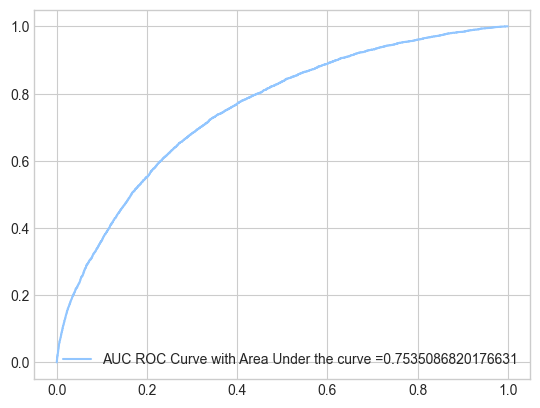

Logistic: f1=0.039 auc=0.233


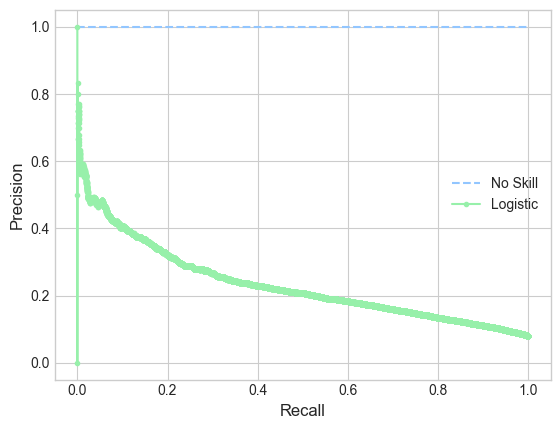

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |          98         |         4786        |
|  Negative class  |          84         |        56535        |
+------------------+---------------------+---------------------+
ROC AUC:  0.5092909595770826
Accuracy =  0.9208168707217534
Precision =  0.5384615384615384
Recall =  0.020065520065520065
F1 Score =  0.038689301223845236
Fbeta Score =  (0.5, 0.92, 0.91)
  model     tn  fp    fn  tp  F

In [39]:
# XGB no SMOTE data   
run_name = "XGB"
print("start train_XGBoost_model")
#best_xgb_model, best_xgb_params, timeXGB = train_XGBoost_model(X_train, Y_train)    
XGB_metrics, best_XGB  = generate_model_report(best_xgb_model, run_name, X_test, Y_test, timeXGB)
#run_MLflow(experiment_name, run_name, XGB_metrics, best_xgb_params, best_xgb_model, X_train)


**2/6 RUN XGB with SMOTE data**

In [15]:
# XGB with SMOTE data   
run_name = "XGB_smote"
XGB_model_smote, best_xfb_params_smote, timeXGBsmote =  train_XGBoost_model(x_train_smote, y_train_smote)
XGB_smote_metrics, best_XGB_smote     = generate_model_report(XGB_model_smote, run_name, X_test, Y_test, timeXGBsmote)
run_MLflow(experiment_name, run_name, XGB_smote_metrics, best_xfb_params_smote, XGB_model_smote, x_train_smote)

NameError: name 'XGB_model_smote' is not defined

**3/6 LightGBM on unbalanced data set**

In [ ]:
run_name = "LightGBM"
LGBM_model, best_LGBM_params, time_LGBM =  train_LightGBM_model(X_train, Y_train)
metrics_LGBM, LGBM_metrics     = generate_model_report(LGBM_model, run_name, X_test, Y_test, time_LGBM)
run_MLflow(experiment_name, run_name, metrics_LGBM, best_LGBM_params, LGBM_model, X_train)

**4/6 LightGBM on smote data set**

In [ ]:
run_name = "LightGBM_smote"
LGBM_smote_model, best_LGBM_smote_params, time_LGBM_smote =  train_LightGBM_model(x_train_smote, y_train_smote)
metrics_LGBM_smote, LGBM_smote_metrics     = generate_model_report(LGBM_smote_model, run_name, X_test, Y_test, time_LGBM_smote)
run_MLflow(experiment_name, run_name, metrics_LGBM_smote, best_LGBM_smote_params,
           LGBM_smote_model, x_train_smote)

**5/6 RFC on unbalanced data set**

In [ ]:
run_name = "RFC"
RFC_model, best_RFC_params, time_RFC = RFC_model(X_train, Y_train)
RFC_metrics, best_metrics_RFC        = generate_model_report(RFC_model, run_name, X_test, Y_test, time_RFC)
run_MLflow(experiment_name, run_name, RFC_metrics, 
           best_RFC_params, RFC_model, X_train)

**6/6 RFC on Smote data set**

In [ ]:
run_name = "RFC_smote"
RFC_model_smote, best_RFC_params_smote, time_RFC_smote = RFC_model(x_train_smote, y_train_smote)
RFC_smote_metrics, best_metrics_RFC_smote              = generate_model_report(RFC_model_smote, run_name, X_test, Y_test, time_RFC_smote)
run_MLflow(experiment_name, run_name, RFC_smote_metrics, 
           best_RFC_params_smote, RFC_model_smote, x_train_smote)

<a name='5'></a>
# 5 Evalutation and selection of best model

In [16]:
# Get the experiment by name
experiment = mlflow.get_experiment_by_name(experiment_name)
print(experiment)
# Get all runs within the experiment
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Create an empty list to store metrics data
metrics_data = []

# Iterate over each run and append its metrics to the list
for index, run in runs.iterrows():
    run_id = run["run_id"]
    #print(run_id)
    run_info = mlflow.get_run(run_id)
    #print(run_info)
    run_name = run_info.data.tags.get("mlflow.runName")
    metrics = run_info.data.metrics
    metrics_data.append({**metrics, "Run Name": run_name})

# Create a DataFrame from the metrics data
metrics_df = pd.DataFrame(metrics_data)
metrics_df.set_index("Run Name", inplace=True)  # Set the run name as the index

#metrics_df['t_in_s'] = round(metrics_df['time_in_s'],0)
metrics_df['t_in_min'] = round(metrics_df['time_in_s']/60,1)
#metrics_df['FP_10_FN'] = round(metrics_df['FP_10_FN'],0)

#metrics_df.drop(['t_in_s'],axis=1, inplace=True)

metrics_df = metrics_df.sort_values(by='FP_10_FN', ascending=True)
#print(round(metrics_df,2))
#metrics_df = round(metrics_df,2)
metrics_out = metrics_df[['FP_10_FN','ROC_AUC','t_in_min','FP','TP','FN','TN','Accuracy','Recall','threshold','Precision','F1']]
metrics_out

<Experiment: artifact_location='mlflow-artifacts:/695381234922981285', creation_time=1709032914891, experiment_id='695381234922981285', last_update_time=1709032914891, lifecycle_stage='active', name='Credit_scoring', tags={'mlflow.note.content': 'This is the credit score project. This experiment '
                        'contains the LightGBM, XGboost and RFC model.',
 'project_name': 'credit-score-classification',
 'project_quarter': 'Q1-2024',
 'store_dept': 'Prêt à dépenser',
 'team': 'cred-ml'}>


,FP_10_FN,ROC_AUC,t_in_min,FP,TP,FN,TN,Accuracy,Recall,threshold,Precision,F1
Run Name,,,,,,,,,,,,
XGB,32675.0,0.683261,14.3,12635.0,2880.0,2004.0,43984.0,0.761979,0.589681,0.1,0.185627,0.282367
XGB,32675.0,0.683261,13.5,12635.0,2880.0,2004.0,43984.0,0.761979,0.589681,0.1,0.185627,0.282367
XGB,32675.0,0.683261,16.1,12635.0,2880.0,2004.0,43984.0,0.761979,0.589681,0.1,0.185627,0.282367
XGB_Shap002,32718.0,0.683261,6.7,12948.0,2907.0,1977.0,43671.0,0.757329,0.595209,0.1,0.183349,0.280341
XGB_Shap002_scaled,32846.0,0.681793,7.1,12836.0,2883.0,2001.0,43783.0,0.758760,0.590295,0.1,0.183409,0.279862
XGB_smote,33112.0,0.686744,3.2,18292.0,3402.0,1482.0,38327.0,0.678487,0.696560,0.3,0.156818,0.256001
XGB_smote,33198.0,0.685774,6.4,18228.0,3387.0,1497.0,38391.0,0.679284,0.693489,0.3,0.156697,0.255632
LightGBM_smote,33281.0,0.681904,5.8,16081.0,3164.0,1720.0,40538.0,0.710567,0.647830,0.3,0.164406,0.262257
LGBM_Shap002_scaled,34979.0,0.663112,8.1,15079.0,2894.0,1990.0,41540.0,0.722469,0.592547,0.2,0.161019,0.253227


In [18]:
X_train.shape

(246008, 239)

In [19]:
#smote 67818
metrics_out['sum'] = metrics_out['FP'] + metrics_out['TP'] + metrics_out['FN'] + metrics_out['TN']
metrics_out

,FP_10_FN,ROC_AUC,t_in_min,FP,TP,FN,TN,Accuracy,Recall,threshold,Precision,F1,sum
Run Name,,,,,,,,,,,,,
XGB,32675.0,0.683261,14.3,12635.0,2880.0,2004.0,43984.0,0.761979,0.589681,0.1,0.185627,0.282367,61503.0
XGB,32675.0,0.683261,13.5,12635.0,2880.0,2004.0,43984.0,0.761979,0.589681,0.1,0.185627,0.282367,61503.0
XGB,32675.0,0.683261,16.1,12635.0,2880.0,2004.0,43984.0,0.761979,0.589681,0.1,0.185627,0.282367,61503.0
XGB_Shap002,32718.0,0.683261,6.7,12948.0,2907.0,1977.0,43671.0,0.757329,0.595209,0.1,0.183349,0.280341,61503.0
XGB_Shap002_scaled,32846.0,0.681793,7.1,12836.0,2883.0,2001.0,43783.0,0.758760,0.590295,0.1,0.183409,0.279862,61503.0
XGB_smote,33112.0,0.686744,3.2,18292.0,3402.0,1482.0,38327.0,0.678487,0.696560,0.3,0.156818,0.256001,61503.0
XGB_smote,33198.0,0.685774,6.4,18228.0,3387.0,1497.0,38391.0,0.679284,0.693489,0.3,0.156697,0.255632,61503.0
LightGBM_smote,33281.0,0.681904,5.8,16081.0,3164.0,1720.0,40538.0,0.710567,0.647830,0.3,0.164406,0.262257,61503.0
LGBM_Shap002_scaled,34979.0,0.663112,8.1,15079.0,2894.0,1990.0,41540.0,0.722469,0.592547,0.2,0.161019,0.253227,61503.0


In [ ]:
print(metrics_df.columns)

In [ ]:
# Load saved model and make predictions
logged_model = 'runs:/546a6c80762547cfb2f52e2cfb9bb735/XGB_artifactPATH'

xgb_classifier_saved = mlflow.pyfunc.load_model(logged_model)

The model **XGB** receives the best business score (FP_10_FN) with 32675, at the same time it has the second highest Accuracy and the second highest Precision.

<a name='6'></a>
# 6 Feature Importance

- get feature importance
- select the features with SHAP values equal 0 and retrain model to assess change

In [ ]:
#feature_names.iloc[:,0].values.tolist()

In [ ]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_names.iloc[:,0].values.tolist(),
    'Importance': RFC_model.feature_importances_
})

# Sorting the DataFrame by importance scores
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

# Displaying the sorted DataFrame
#feature_importance_df_sorted['Feature'][:20].tolist()

In [ ]:
# Select columns with data type 'int64'
int_columns = X_train.select_dtypes(include=['int64']).columns

# Convert selected columns to int
X_train[int_columns] = X_train[int_columns].astype('float')
# Select columns with data type 'int64'
int_columns = X_train.select_dtypes(include=['bool']).columns

# Convert selected columns to int
X_train[int_columns] = X_train[int_columns].astype('float')
#X_train.info()

**Conversion of type of the test data**

In [ ]:
test = X_train.copy()
test["ID"] = ids_test
test.set_index("ID", inplace=True)
ids_test.iloc[5]
#test.loc[100008].values.tolist()
data_point = test.loc[100030].values.tolist()


In [ ]:
data_P = pd.DataFrame(data_point)
data_P.shape

In [ ]:
explainer = shap.Explainer(best_xgb_model, X_train)

shap_values = explainer.shap_values(data_P)
shap_df = pd.DataFrame({'Feature': X.columns, 'SHAP Value': shap_values[0]})
print("\nSHAP Values:")
print(shap_df)

In [ ]:
explainer = shap.Explainer(best_xgb_model, X_train)
#explainer = shap.Explainer(xgb_classifier_saved, X_train)

shap_values = explainer.shap_values(X_train)
shap_df = pd.DataFrame({'Feature': feature_names['0'].tolist(), 'SHAP Value': shap_values[0]})
print("\n SHAP Values:")
# Sort shap_df by the 'SHAP Value' column in ascending order
sorted_shap_df = shap_df.sort_values(by='SHAP Value')

# Print the sorted DataFrame
print(sorted_shap_df)

In [ ]:
shap_df.to_csv('3_Streamlit_dashboard/data/shap_df.csv', index = False)


In [ ]:
shap.summary_plot(shap_values, shap_df['Feature'], plot_type="bar")

In [ ]:
#pip install --upgrade xgboost 
#pip install xgboost==1.7.6

In [ ]:
print(xgb.__version__)

In [ ]:
#!pip freeze #> requirements.txt

<a name='7'></a>
## 7 Feature Selection after SHAP feature Importance

## Filter not useful features

In [ ]:
# Displaying the sorted DataFrame
SHAP_feature_important_001 = shap_df[abs(shap_df['SHAP Value'])>0.001]['Feature'].tolist()
len(SHAP_feature_important)

Retrain

In [ ]:
len(SHAP_feature_unimportant)

In [ ]:
len(SHAP_feature_important)

In [ ]:
#SHAP_feature_important

In [ ]:
X_train.head()

In [ ]:
def select_columns(X_train, feature_names, shap_df, threshold):
    SHAP_feature_important = shap_df[abs(shap_df['SHAP Value'])>threshold]['Feature'].tolist()
    print("length important features ", len(SHAP_feature_important))
    df = X_train.copy()
    df.columns = feature_names['0'].tolist()
    df = df[SHAP_feature_important]
    # Remove all column names
    #df.rename(columns={x:y for x,y in zip(df.columns,range(0,len(df.columns)))})
    df.columns = [x for x in range(0, len(df.columns))] 
    print(df.shape)
    #print(df.info())
    print(df.head())
    return df

### First attempt to improve feature selection and model training

In [ ]:
new_X_train = select_columns(X_train, feature_names, shap_df, 0.001)
new_X_test  = select_columns(X_test, feature_names, shap_df, 0.001)

In [ ]:
run_name = "RFC_newFEATURE_001"
RFC_model_001, best_RFC_params, time_RFC = RFC_model(new_X_train, Y_train)
RFC_metrics, best_metrics_RFC        = generate_model_report(RFC_model_001, run_name, new_X_test, Y_test, time_RFC)
run_MLflow(experiment_name, run_name, RFC_metrics, 
           best_RFC_params, RFC_model_001, new_X_train)

### Second attempt to improve feature selection and model improvement

In [ ]:
new_X_train_002 = select_columns(X_train, feature_names, shap_df, 0.002)
new_X_test_002  = select_columns(X_test, feature_names, shap_df, 0.002)

X_train_002_scaled, X_test_002_scaled  = scale_data(new_X_train_002, new_X_test_002 )


In [ ]:
run_name = "RFC_newFEATURE_002"
RFC_model_002, best_RFC_params, time_RFC = RFC_model(new_X_train_002, Y_train)
RFC_metrics, best_metrics_RFC            = generate_model_report(RFC_model_002, run_name, new_X_test_002, Y_test, time_RFC)
run_MLflow(experiment_name, run_name, RFC_metrics, 
           best_RFC_params, RFC_model_002, new_X_train_002)

In [ ]:
run_name = "XGB_Shap002"
XGB_model_002, XGB_002_params, time_XGB_002 = train_XGBoost_model(new_X_train_002, Y_train)
XGB_002_metrics, best_metrics_XGB           = generate_model_report(XGB_model_002, run_name, new_X_test_002, Y_test, time_XGB_002)
run_MLflow(experiment_name, run_name, XGB_002_metrics, 
           XGB_002_params, XGB_model_002, new_X_train_002)


In [ ]:
run_name = "LGBM_Shap002"
LGBM_model_002, LGBM_002_params, time_LGBM_002 = train_LightGBM_model(new_X_train_002, Y_train)
LGBM_002_metrics, best_metrics_LGBM           = generate_model_report(LGBM_model_002, run_name, new_X_test_002, Y_test, time_LGBM_002)
run_MLflow(experiment_name, run_name, LGBM_002_metrics, 
           LGBM_002_params, LGBM_model_002, new_X_train_002)

In [ ]:
new_X_train_002.head()

## Run with Shap filtered and scaled data to assess impact on metrics

In [ ]:
X_train_002_scale, X_test_002_scale = scale_data(new_X_train_002, new_X_test_002)

In [ ]:
run_name = "LGBM_Shap002_scaled"
#LGBM_model_002_scale, LGBM_002_scale_params, time_LGBM_002 = train_LightGBM_model(X_train_002_scale, Y_train)
#LGBM_002_scale_metrics, best_metrics_LGBM_scale           = generate_model_report(LGBM_model_002_scale, run_name, X_test_002_scale, Y_test, time_LGBM_002)
run_MLflow(experiment_name, run_name, LGBM_002_scale_metrics, 
           LGBM_002_scale_params, LGBM_model_002_scale, X_train_002_scale)

In [ ]:
run_name = "XGB_Shap002_scaled"
XGB_model_002_scaled, XGB_002_scaled_params, time_XGB_002_scaled = train_XGBoost_model(X_train_002_scale, Y_train)
XGB_002_scaled_metrics, best_metrics_XGB_scaled           = generate_model_report(XGB_model_002_scaled, run_name, X_test_002_scale, Y_test, time_XGB_002_scaled)
run_MLflow(experiment_name, run_name, XGB_002_scaled_metrics, 
           XGB_002_scaled_params, XGB_model_002_scaled, X_train_002_scale)

## Test MLflow on Fastapi model serving

In [ ]:
!curl http://127.0.0.1:8000/predict -H 'Content-Type: application/json' -d '{"inputs": [[0, 0, 1, 1, 63000.0, 310500.0, 15232.5, 310500.0, 0.026392, 16263, -214.0, -8930.0, -573, 0.0, 1, 1, 0, 1, 1, 0, 2.0, 2, 2, 11, 0, 0, 0, 0, 1, 1, 0.0, 0.0765011930557638, 0.0005272652387098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, true, false, false, false, false, false, false, false, true, false, false, false, false, false, false, true, false, false, false, false, true, false, false, false, true, false, false, true, false, false, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false]]}'
  

In [ ]:
!curl http://127.0.0.1:8000/predict -H 'Content-Type: application/json' -d '{"data_point": [[0, 0, 1, 1, 63000.0, 310500.0, 15232.5, 310500.0, 0.026392, 16263, -214.0, -8930.0, -573, 0.0, 1, 1, 0, 1, 1, 0, 2.0, 2, 2, 11, 0, 0, 0, 0, 1, 1, 0.0, 0.0765011930557638, 0.0005272652387098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, true, false, false, false, false, false, false, false, true, false, false, false, false, false, false, true, false, false, false, false, true, false, false, false, true, false, false, true, false, false, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false]]}'


In [ ]:
X_train.info()

**Selection of a data point for testing**

In [ ]:
test = X_train.copy()
test["ID"] = ids_test
test.set_index("ID", inplace=True)
ids_test.iloc[5]
#test.loc[100008].values.tolist()
data_for_request = test.loc[100030].values.tolist()

In [ ]:
#data_for_request

In [ ]:
import requests

# initialised with: mlflow models serve -m model_LGBM02/ --port 8092
#http://127.0.0.1:8092

host = '127.0.0.1'
port = '8000'

# endpoint
url = f'http://{host}:{port}/predict'
print("URI : ", url)
headers = {
    'Content-Type': 'application/json',
}

headers = {'Content-Type': 'application/json'}

# Send the POST request with the data
response = requests.post(url, json={"data_point": data_for_request})

print(f'Predictions: {response.text}')

**TEST with empty data set**

In [ ]:
# Send the POST request with the data
response = requests.post(url, json={"data_point":[]})

print(f'Predictions: {response.text}')

**TEST on hosting environment**

In [ ]:
url = 'https://fastapi-cd-webapp.azurewebsites.net/predict'
# Send the POST request with the data
response = requests.post(url, json={"data_point": data_for_request})

print(f'Predictions: {response.text}')